In [38]:
import pandas as pd
import spacy
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Lambda, Input, Layer
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.feature_extraction.text import CountVectorizer
import itertools
import math
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import seaborn as sns

# Load spacy model
nlp = spacy.load('en_core_web_sm')

In [39]:
from groq import Groq
import dotenv
import os

dotenv.load_dotenv()

True

## Metrics
1. Perplexity: metric used in topic modeling to evaluate how well the model generalizes to unseen data. Measures how likely the model is to assign high probabilities to the words in a test set based on the learned topics. Lower perplexity = better generalization
2. Coherence score: quality of the topics by measuring the semantic similarity of the top words in each topic. Higher coherence scores indicate that the words in the topic are more related, which generally leads to better interpretability. Usually between 0-1, higher than 0.4 is good.
3. Topic diversity: how distinct the topics are from each other. Usually between 0-1, above 0.7 is good. 

In [40]:
groq_api_key = os.getenv("GROQ_API_KEY")
print(groq_api_key)

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


In [41]:
# Sample data
df = pd.read_csv("../data/processed_reviews.csv")
# subcategories = ['SPRAY CLEANERS BLEACH CLEANERS', 'BODY CARE BODY LOTION', 'WOOD/FURNITURE/DUST', 'WOOD/FURNITURE CLEANER']
subcategories = ['SPRAY CLEANERS BLEACH CLEANERS']
df_sample = df[df['subcategory'].isin(subcategories)]

In [42]:
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(df_sample['review_text'])
# sequences = tokenizer.texts_to_sequences(df_sample['review_text'])

# # Train Word2Vec model on tokenized text
# sentences = [text.split() for text in df_sample['review_text']]
# word2vec_model = Word2Vec(sentences, vector_size=100, window=3, min_count=5, sg=1, sample=1e-3, epochs=20)
# word_vectors = word2vec_model.wv

In [43]:
# vocab_size = len(tokenizer.word_index) + 1
# embedding_matrix = np.zeros((vocab_size, 100))
# for word, i in tokenizer.word_index.items():
#     if word in word_vectors:
#         embedding_matrix[i] = word_vectors[word]

In [44]:
# from tensorflow.keras.layers import Reshape

# # Custom layer to add document and word embeddings without reducing over timesteps
# class LDA2VecEmbedding(Layer):
#     def call(self, inputs):
#         word_embedding, doc_embedding = inputs
#         # Add doc_embedding to each timestep in the word embeddings sequence
#         doc_embedding_expanded = tf.repeat(doc_embedding, repeats=tf.shape(word_embedding)[1], axis=1)
#         doc_word_embeddings = word_embedding + doc_embedding_expanded
#         return doc_word_embeddings

# # Model inputs
# doc_input = Input(shape=(1,), dtype='int32', name='doc_input')
# word_input = Input(shape=(None,), dtype='int32', name='word_input')

# # Document and word embeddings
# # doc_embedding = Embedding(input_dim=len(df_sample), output_dim=300)(doc_input)
# # word_embedding = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], trainable=True)(word_input)

# word_embedding = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=True)(word_input)
# doc_embedding = Embedding(input_dim=len(df_sample), output_dim=100)(doc_input)


# # Use the custom layer to combine embeddings
# doc_word_embeddings = LDA2VecEmbedding()([word_embedding, doc_embedding])

# # Reshape doc_word_embeddings to have 3 dimensions (batch_size, sequence_length, embedding_dim)
# output = TimeDistributed(Dense(vocab_size, activation='softmax'))(doc_word_embeddings)

# # Build and compile model
# lda2vec_model = Model(inputs=[doc_input, word_input], outputs=output)
# lda2vec_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')


In [45]:
# # Convert documents to sequences
# doc_indices = np.arange(len(df_sample)).reshape(-1, 1)
# max_length = max(len(seq) for seq in sequences)  # Determine the max length in your sequences
# word_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# # Train model
# lda2vec_model.fit([doc_indices, word_sequences], word_sequences, batch_size=64, epochs=10)

In [46]:
# # Extract document and word embeddings
# doc_embeddings = lda2vec_model.get_layer('doc_embedding').get_weights()[0]
# word_embeddings = lda2vec_model.get_layer('word_embedding').get_weights()[0]

# # Function to get similar words for topics
# def get_similar_words(embedding, top_n=10):
#     from sklearn.metrics.pairwise import cosine_similarity
#     sim_scores = cosine_similarity(embedding, word_embeddings)
#     top_words = [np.argsort(sim_scores[i])[-top_n:] for i in range(sim_scores.shape[0])]
#     return [[tokenizer.index_word[idx] for idx in words] for words in top_words]

# # Display topics
# topics = get_similar_words(doc_embeddings)
# print("Topics generated by LDA2Vec:")
# for i, topic in enumerate(topics):
#     print(f"Topic {i+1}: {topic}")

In [47]:
def preprocess(text):
    text = text.lower()
    doc = nlp(text, disable=["ner", "parser"])
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

In [48]:
df_sample['tokens'] = df_sample['review_text'].apply(preprocess)

C:\Users\melod\AppData\Local\Temp\ipykernel_48984\40310906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['tokens'] = df_sample['review_text'].apply(preprocess)


In [49]:
client = Groq(api_key=groq_api_key)
model = 'llama3-8b-8192'

def refine_topic(client, model, top_words, rating):
    system_message = """
    Generate a concise and coherent phrase that summarizes topics based on provided keywords
    and associated review ratings. The keywords are ordered by relevance from the most to the least.


    Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic.
    For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback.
    Omit pronouns and conjunctions to keep the phrase succinct.


    For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and
    be as detailed as possible.


    Output only the phrase without additional commentary.


    Example:


    Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
    Output: "Leaking or damaged items and boxes upon delivery"
    """
    user_message =  f'Input: "{top_words}" rating: {rating}'
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": user_message
            }
        ],
        model=model
    )

    # Retrieve the response from the model
    response = chat_completion.choices[0].message.content

    # Split the response into lines and return the last line
    response_lines = response.split('\n')
    clean_response = response_lines[-1].strip()  # Keep only the last line, stripping any whitespace
    
    return clean_response

In [50]:
def calculate_topic_diversity(topics, top_n=10):
    unique_words = set()
    total_words = 0
    
    for topic_id, topic_words in topics:
        words = [word for word, _ in topic_words[:top_n]]  # Extract top_n words
        unique_words.update(words)
        total_words += len(words)
    
    # Topic diversity is the ratio of unique words to total words
    diversity = len(unique_words) / total_words
    return diversity

In [51]:
def get_number_topics(num_reviews):
    if num_reviews > 50000:
        return 20
    if num_reviews > 25000:
        return 15
    if num_reviews > 10000:
        return 10
    if num_reviews > 5000:
        return 8
    if num_reviews > 1000:
        return 6
    if num_reviews > 500:
        return 5
    if num_reviews > 100:
        return 4
    if num_reviews > 50:
        return 3
    if num_reviews > 10:
        return 2
    return 1

In [52]:
# def calculate_num_topics_star_rating(total_topics, star_rating, min_topics=1):
#     # weighting based on star rating--lower star ratings get higher weights
#     weight = (6 - star_rating) 
    
#     # normalize weight: ensure the sum of the topics does not exceed total_topics
#     total_weight = sum(6 - r for r in range(1, 6))
#     normalized_weight = weight / total_weight

#     # calculate the number of topics for the group based on normalized weight
#     num_topics = max(min_topics, math.ceil(normalized_weight * total_topics))

#     return num_topics
def calculate_num_topics_star_rating(total_topics, star_rating, min_topics=1):
    # logarathmic weighting (smooth it out)
    weight = math.log(6 - star_rating + 1)  # Adding 1 to avoid log(0)

    # normalize weight to ensure sum of the topics is not greater than total_topics
    total_weight = sum(math.log(6 - r + 1) for r in range(1, 6))
    normalized_weight = weight / total_weight

    # number of topics for the group based on normalized weight
    num_topics = max(min_topics, math.ceil(normalized_weight * total_topics))

    return num_topics

In [53]:
def topic_modeling_with_labels(df, client, model):
    # Group by subcategory and star_rating
    grouped = df.groupby(['subcategory', 'star_rating'])
    
    # Dictionary to store topic labels for each (subcategory, star_rating) group
    topic_label_mapping = {}
    
    # Loop through each (subcategory, star_rating) group
    for (subcategory, star_rating), group in grouped:
        print(f"Processing subcategory: {subcategory} with star rating: {star_rating}")
        
        # Total size of the subcategory (for proportional topic assignment)
        subcategory_size = df[df['subcategory'] == subcategory].shape[0]
        group_size = group.shape[0]

        # Get the total number of topics for the entire subcategory
        total_topics = get_number_topics(subcategory_size)
        print(f"Assigning {total_topics} topics for subcategory {subcategory}")
        
        # Calculate the number of topics based on the size of the group
        num_topics = calculate_num_topics_star_rating(total_topics, star_rating)
        print(f"Assigning {num_topics} topics for {group_size} reviews (star rating {star_rating}) in subcategory {subcategory}")
        
        # Dictionary and corpus for LDA
        dictionary = Dictionary(group['tokens'])
        corpus = [dictionary.doc2bow(text) for text in group['tokens']]
        
        # Train the LDA model
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

        # Evaluate perplexity
        # perplexity = lda_model.log_perplexity(corpus)
        # print(f"Perplexity for subcategory {subcategory}, star rating {star_rating}: {perplexity}")

        # Evaluate coherence score
        # coherence_model = CoherenceModel(model=lda_model, texts=group['tokens'], dictionary=dictionary, coherence='c_v')
        # coherence_score = coherence_model.get_coherence()
        # print(f"Coherence Score for subcategory {subcategory}, star rating {star_rating}: {coherence_score}")
        
        # Extract the top words for each topic
        lda_topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
        
        # Refine topic labels using Groq API
        lda2vec_topic_labels = []
        for topic_id, topic_words in lda_topics:
            # Extract the words from the topic tuple
            topic_word_list = [word for word, _ in topic_words]
            
            # Refine the topic label using Groq API
            lda2vec_topic_label = refine_topic(client, model, topic_word_list, star_rating)
            lda2vec_topic_labels.append(lda2vec_topic_label)
            # print(f"Refined Label for Topic {topic_id}: {lda2vec_topic_label}")
        
        # Create a mapping from LDA topic ID to the refined topic label
        for topic_id, label in enumerate(lda2vec_topic_labels):
            topic_label_mapping[(subcategory, star_rating, topic_id)] = label
        
        # topic_diversity = calculate_topic_diversity(lda_topics)
        # print(f"Topic Diversity for subcategory {subcategory}, star rating {star_rating}: {topic_diversity}")
        
        # Add LDA topics to the original DataFrame using .loc[]
        df.loc[group.index, 'LDA_topic'] = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
    
        # Debugging: Print all keys in the mapping to check for missing keys
        print(f"Keys in topic_label_mapping: {list(topic_label_mapping.keys())}")

        # Now, map the refined topic labels back to the original DataFrame
        df['LDA2Vec_topic_label'] = df.apply(
            lambda row: topic_label_mapping.get(
                (row['subcategory'], row['star_rating'], row['LDA_topic']),
                "Unknown Topic"  # Default value for missing keys
            ), 
            axis=1
        )
    
    return df

# Apply the function to add the topic labels to df_sample
df_sample = topic_modeling_with_labels(df_sample, client, model)


Processing subcategory: SPRAY CLEANERS BLEACH CLEANERS with star rating: 1.0
Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 2 topics for 272 reviews (star rating 1.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS


C:\Users\melod\AppData\Local\Temp\ipykernel_48984\615680994.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[group.index, 'LDA_topic'] = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
C:\Users\melod\AppData\Local\Temp\ipykernel_48984\615680994.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LDA2Vec_topic_label'] = df.apply(


Keys in topic_label_mapping: [('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 1)]
Processing subcategory: SPRAY CLEANERS BLEACH CLEANERS with star rating: 2.0
Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 2 topics for 97 reviews (star rating 2.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS
Keys in topic_label_mapping: [('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 1)]
Processing subcategory: SPRAY CLEANERS BLEACH CLEANERS with star rating: 3.0
Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 2 topics for 165 reviews (star rating 3.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS


C:\Users\melod\AppData\Local\Temp\ipykernel_48984\615680994.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LDA2Vec_topic_label'] = df.apply(


Keys in topic_label_mapping: [('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 3.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 3.0, 1)]
Processing subcategory: SPRAY CLEANERS BLEACH CLEANERS with star rating: 4.0
Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 2 topics for 420 reviews (star rating 4.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS


C:\Users\melod\AppData\Local\Temp\ipykernel_48984\615680994.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LDA2Vec_topic_label'] = df.apply(


Keys in topic_label_mapping: [('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 3.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 3.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 4.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 4.0, 1)]
Processing subcategory: SPRAY CLEANERS BLEACH CLEANERS with star rating: 5.0
Assigning 6 topics for subcategory SPRAY CLEANERS BLEACH CLEANERS
Assigning 1 topics for 3777 reviews (star rating 5.0) in subcategory SPRAY CLEANERS BLEACH CLEANERS


C:\Users\melod\AppData\Local\Temp\ipykernel_48984\615680994.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LDA2Vec_topic_label'] = df.apply(


Keys in topic_label_mapping: [('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 1.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 2.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 3.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 3.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 4.0, 0), ('SPRAY CLEANERS BLEACH CLEANERS', 4.0, 1), ('SPRAY CLEANERS BLEACH CLEANERS', 5.0, 0)]


C:\Users\melod\AppData\Local\Temp\ipykernel_48984\615680994.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LDA2Vec_topic_label'] = df.apply(


In [54]:
# save as csv
# df_sample.to_csv('reviews_with_lda_topics.csv', index=False)

In [55]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'tokens', 'LDA_topic', 'LDA2Vec_topic_label'],
      dtype='object')

In [66]:
subcategories = ['SPRAY CLEANERS BLEACH CLEANERS']
for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory']==subcategory]
    for brand_type in df_subcategory['brand_type'].unique():
        df_brand = df_subcategory[df_subcategory['brand_type']==brand_type]
        print(f"Topics for subcategory: {subcategory} and brand: {brand_type}")
        print(df_brand['LDA2Vec_topic_label'].value_counts())
        print(" ")

Topics for subcategory: SPRAY CLEANERS BLEACH CLEANERS and brand: Clorox
LDA2Vec_topic_label
"Great cleaning product with pleasant bathroom smell"                                 3503
"Clean bathroom effectively with great smelling bleach spray"                          286
"Not leak-proof bleach products received"                                              124
"Defective product, leaked bleach, poor order"                                         121
"Good experience with Clorox spray product"                                            102
"Ordered product may not spray leaklessly"                                              78
"Effective and pleasant cleaning spray, good smell, but not as great as expected."      65
"Defective or non-functional bottle and box"                                            46
"Not-so-good smelling product with some using concerns"                                 35
Name: count, dtype: int64
 
Topics for subcategory: SPRAY CLEANERS BLEACH CLEANERS and b

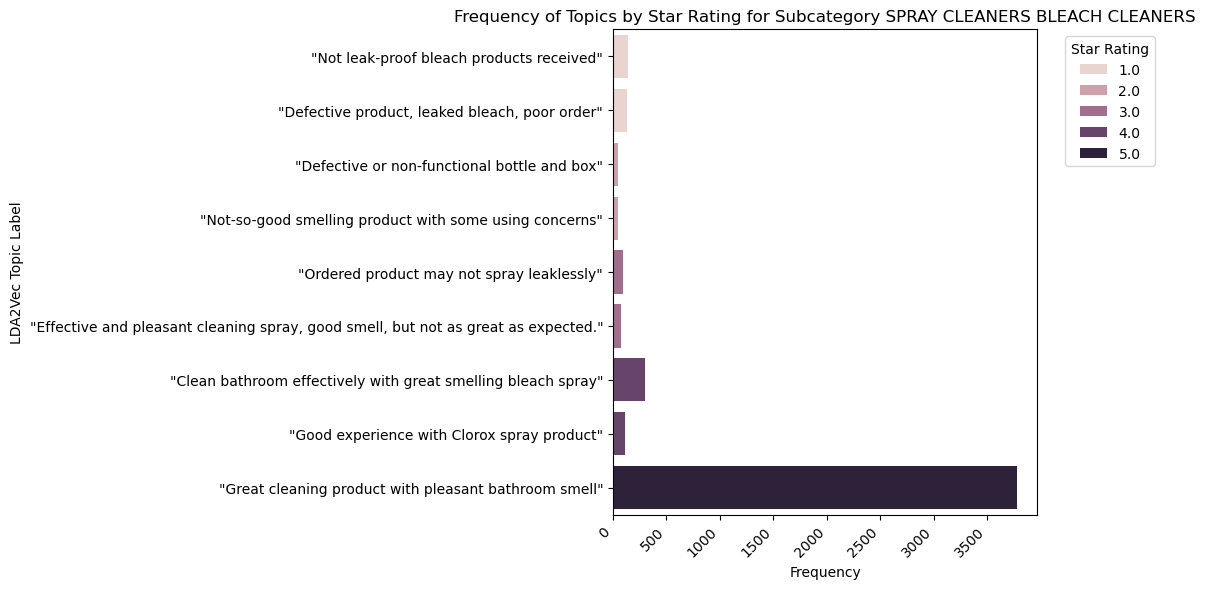

In [67]:
for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory']==subcategory]
    df_subcategory_grouped_df = df_subcategory.groupby('star_rating')['LDA2Vec_topic_label'].value_counts().reset_index(name='count')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_subcategory_grouped_df, x='count', y='LDA2Vec_topic_label', hue='star_rating', dodge=False)

    # Customize the plot
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Frequency of Topics by Star Rating for Subcategory {subcategory}')
    plt.xlabel('Frequency')
    plt.ylabel('LDA2Vec Topic Label')
    plt.legend(title='Star Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [68]:
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

def similarity_scores(model_name, df):
   model = SentenceTransformer(model_name)
   reviews = df['review_text'].tolist()
   phrases = df['LDA2Vec_topic_label'].tolist()
   review_embeddings = model.encode(reviews, convert_to_tensor=True)
   phrase_embeddings = model.encode(phrases, convert_to_tensor=True)
   similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
   return similarity_scores

In [69]:
similarity_scores = similarity_scores('all-MiniLM-L6-v2', df_sample)

c:\Users\melod\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [70]:
print(similarity_scores)

[0.07160603 0.5449707  0.2668787  ... 0.3847584  0.3785109  0.48870254]


In [71]:
# add similarity scores to dataframe
df_sample['similarity_score'] = similarity_scores

C:\Users\melod\AppData\Local\Temp\ipykernel_48984\55219579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['similarity_score'] = similarity_scores


In [72]:
df_sample['similarity_score'].mean()

0.41844365

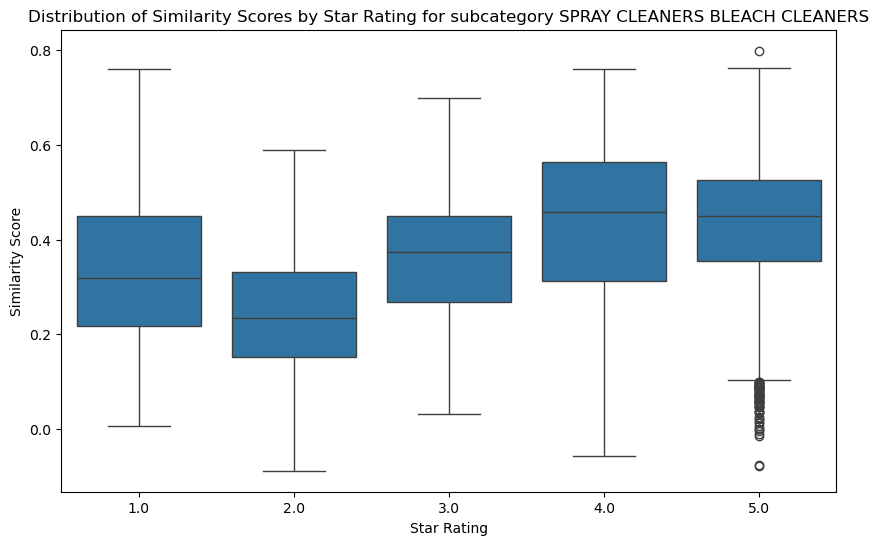

In [73]:
for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory']==subcategory]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_subcategory, x='star_rating', y='similarity_score')
    plt.title(f'Distribution of Similarity Scores by Star Rating for subcategory {subcategory}')
    plt.xlabel('Star Rating')
    plt.ylabel('Similarity Score')
    plt.show()

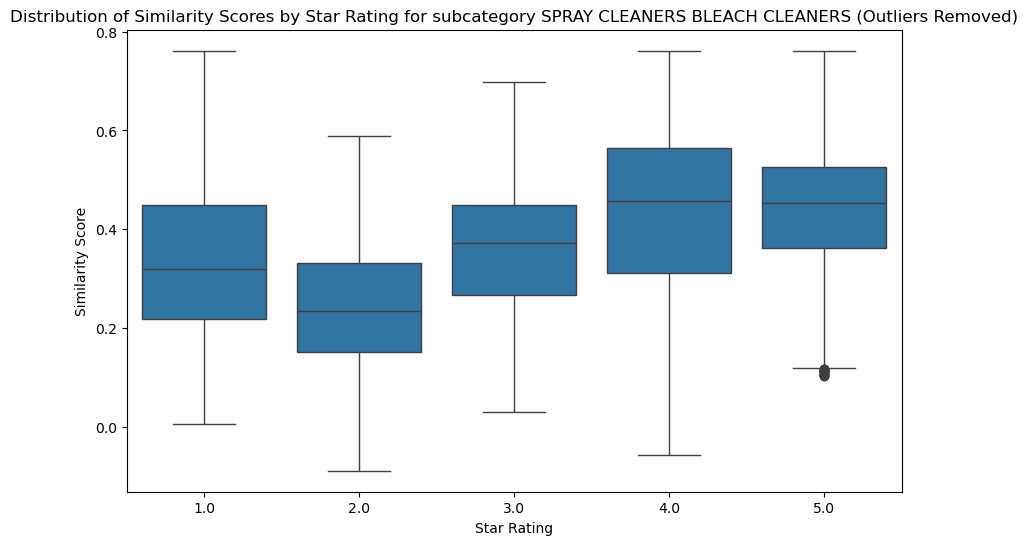

In [74]:
# similarity scores without outliers
filtered_df = pd.DataFrame()  # Initialize an empty DataFrame to store filtered data

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR for similarity_score
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        df_filtered = df_rating[(df_rating['similarity_score'] >= lower_bound) & (df_rating['similarity_score'] <= upper_bound)]
        
        # Append filtered data to the new DataFrame
        filtered_df = pd.concat([filtered_df, df_filtered])

# Plot boxplot without outliers
for subcategory in subcategories:
    df_subcategory = filtered_df[filtered_df['subcategory'] == subcategory]
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_subcategory, x='star_rating', y='similarity_score')
    plt.title(f'Distribution of Similarity Scores by Star Rating for subcategory {subcategory} (Outliers Removed)')
    plt.xlabel('Star Rating')
    plt.ylabel('Similarity Score')
    plt.show()


In [36]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'tokens', 'LDA_topic', 'LDA2Vec_topic_label', 'similarity_score'],
      dtype='object')

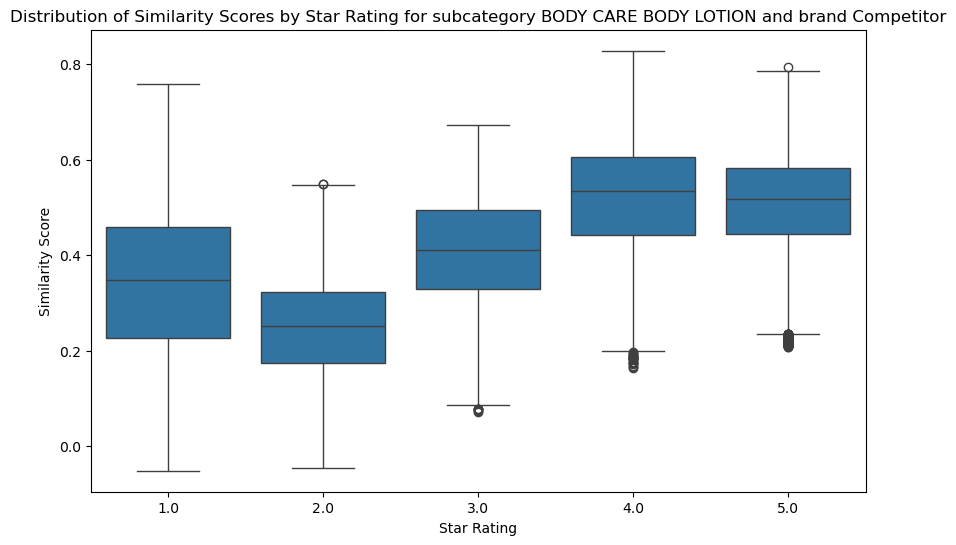

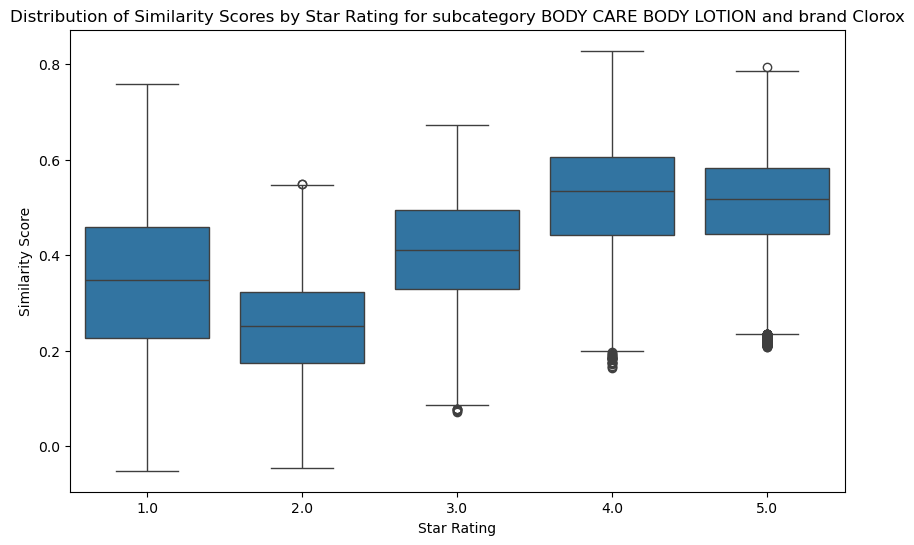

In [38]:
# similarity scores without outliers
filtered_df = pd.DataFrame()  # Initialize an empty DataFrame to store filtered data

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR for similarity_score
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        df_filtered = df_rating[(df_rating['similarity_score'] >= lower_bound) & (df_rating['similarity_score'] <= upper_bound)]
        
        # Append filtered data to the new DataFrame
        filtered_df = pd.concat([filtered_df, df_filtered])

# Plot boxplot without outliers
for subcategory in subcategories:
    df_subcategory = filtered_df[filtered_df['subcategory'] == subcategory]
    for brand in df_subcategory['brand_type'].unique():
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_subcategory, x='star_rating', y='similarity_score')
        plt.title(f'Distribution of Similarity Scores by Star Rating for subcategory {subcategory} and brand {brand}')
        plt.xlabel('Star Rating')
        plt.ylabel('Similarity Score')
        plt.show()


In [75]:
outliers = []

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df_outliers = df_rating[(df_rating['similarity_score'] < lower_bound) | (df_rating['similarity_score'] > upper_bound)]
        
        # Append the outliers with additional details
        if not df_outliers.empty:
            outliers.append({
                'subcategory': subcategory,
                'star_rating': star_rating,
                'outliers': df_outliers[['review_text', 'similarity_score']]
            })

# Display the outliers for each subcategory and star rating
for outlier_info in outliers:
    print(f"Outliers in subcategory '{outlier_info['subcategory']}' with star rating {outlier_info['star_rating']}:")
    print(outlier_info['outliers'])

Outliers in subcategory 'SPRAY CLEANERS BLEACH CLEANERS' with star rating 5.0:
                                              review_text  similarity_score
11                   it do the work that be enough for me          0.071606
3645                     serve the purpose get the job do          0.094993
4133    i get everything i want 26 the price be reason...          0.056112
4371                                       luv this stuff          0.092794
4486    bang for my buck i get two for less than 10 de...          0.035946
...                                                   ...               ...
194695      do the job and the price be right up my alley          0.091449
197494                          last me about half a year          0.099954
197928                                  it work perfectly          0.099682
199603                         buy in bulk to reduce cost          0.057198
200074  hello stephanie weve if i loose it all if i lo...          0.011703

[75 rows

In [ ]:
outliers = []

for subcategory in subcategories:
    df_subcategory = df_sample[df_sample['subcategory'] == subcategory]
    
    for star_rating in df_subcategory['star_rating'].unique():
        df_rating = df_subcategory[df_subcategory['star_rating'] == star_rating]
        
        # Calculate Q1, Q3, and IQR
        Q1 = df_rating['similarity_score'].quantile(0.25)
        Q3 = df_rating['similarity_score'].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df_outliers = df_rating[(df_rating['similarity_score'] < lower_bound) | (df_rating['similarity_score'] > upper_bound)]
        
        # Append the outliers with additional details
        if not df_outliers.empty:
            outliers.append({
                'subcategory': subcategory,
                'star_rating': star_rating,
                'outliers': df_outliers[['review_text', 'similarity_score']]
            })

# Display the outliers for each subcategory and star rating
for outlier_info in outliers:
    print(f"Outliers in subcategory '{outlier_info['subcategory']}' with star rating {outlier_info['star_rating']}:")
    print(outlier_info['outliers'])

In [21]:
def sample_by_star_rating(df, star_rating, sample_size):
    subset = df[df['star_rating'] == star_rating]
    return subset.sample(n=min(sample_size, len(subset)), random_state=42)

# Sample subsets for each star rating (1 to 5)
samples = [sample_by_star_rating(df_sample, rating, 5) for rating in range(1, 6)]

# Combine the sampled subsets into one DataFrame
sampled_df = pd.concat(samples, ignore_index=True)
sampled_df[['review_text', 'star_rating', 'LDA2Vec_topic_label']]

,review_text,star_rating,LDA2Vec_topic_label
0,it smell disgust and doesnt moisturize whatsoever,1.0,"""Old formula or new scent not used"""
1,if i be write this review last year i would be...,1.0,"""Not satisfied with product formula."""
2,mid smell overrate and doesnt last long,1.0,"""Not effective new lotion for dry skin"""
3,why be this change previously great product no...,1.0,"""Not satisfied with product formula."""
4,i think the lotion would probably be fine but ...,1.0,"""Old formula or new scent not used"""
5,i buy this think it be the same scent as the o...,2.0,"""Not as good on skin as expected"""
6,smell okay but the pump stop work after two us,2.0,"""Not good lotion use"""
7,this lotion for dry sensitive skin use to be e...,2.0,"""Not as good on skin as expected"""
8,great product terrible packaging please update...,2.0,Not a pleasant experience
9,i buy this because another reviewer say it sme...,2.0,Not a pleasant experience


In [22]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'tokens', 'LDA_topic', 'LDA2Vec_topic_label', 'similarity_score'],
      dtype='object')

In [23]:
df['subcategory'].value_counts().head(50)

subcategory
FACE CARE FACIAL MOISTURIZERS                     81938
FACE CARE FACIAL CLEANSERS                        80514
FACE CARE ACNE TREATMENTS                         46202
FACE CARE FACIAL TOWELETTES                       43130
FACE CARE FACIAL TREATMENTS                       37345
BODY CARE BODY WASH                               28433
WIPES DISINFECTING WIPES                          22595
ODOR CONTROLLING DISINFECTING SPRAYS              20806
BODY CARE BODY LOTION                             20281
LIP CARE LIP BALM                                 19107
FLOOR CLEANERS CONVENIENCE                        17318
SPRAY CLEANERS ALL PURPOSE CLEANERS               16896
BODY CARE                                         14068
DRAIN CARE                                        12212
AIR FRESHENER                                     11161
DILUTABLES SCENTED/NON-DISINFECTING DILUTABLES    10754
ODOR CONTROLLING AIR FRESHENERS                    9877
CONSUMABLE TOOLS CONSUMABLE SCRUBBER

In [25]:
df_sample.columns

Index(['brand', 'product_title', 'proxy_date', 'retailer', 'category',
       'subcategory', 'review_text', 'star_rating', 'topic', 'brand_type',
       'tokens', 'LDA_topic', 'LDA2Vec_topic_label', 'similarity_score'],
      dtype='object')

In [26]:
df_sample.to_csv('../outputs/lda2vec_body_lotion.csv')

In [77]:
df_sample.to_csv('../outputs/lda2vec_spray_cleaners.csv')